<a href="https://colab.research.google.com/github/sfarrukhm/making_models_small/blob/main/making_transformers_efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU transformers datasets evaluate

In [2]:
import torch
from pathlib import Path
import numpy as np
from time import perf_counter
from transformers import pipeline
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification,AutoTokenizer

## Load data and model

In [7]:
clinc_data = load_dataset("clinc_oos", "plus")
intents = clinc_data["test"].features["intent"]

model_checkpoint="transformersbook/bert-base-uncased-finetuned-clinc"
teacher_pipeline=pipeline("text-classification",model=model_checkpoint)


Device set to use cuda:0


In [8]:
print(clinc_data)

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})


In [6]:
print(intents)

ClassLabel(names=['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations', 'smart_home', 'user_name', 'report_lost_card', 'repeat', 'whisper_mode', 'what_are_your_hobbies', 'order', 'jump_start', 'schedule_meeting', 'meeting_schedule', 'freeze_account', 'what_song', 'meaning_of_life', 'restaurant_reservation', 'traffic', 'make_call', 'text', 'bill_balance', 'improve_credit_score', 'change_language', 'no', 'measurement_conversion', 'timer', 'flip_coin', 'do_you_have_pets', 'balance', 'tell_joke', 'last_maintenance', 'exchange_rate', 'uber', 'car_rental', 'credit_limit', 'oos', 'shopping_list', 'expiration_date', 'routing', 'meal_suggestion', 'tire_change', 'todo_list', 'card_declined', 'rewards_balance', 'change_accent', 'vaccines', 'reminder_update', 'food_last', 'change_ai_name', 'bill_due', 'who_do_you_work_for', 'share_location', 'international_visa', 'calendar', 'translate',

In [9]:
import evaluate
accuracy_score=evaluate.load('accuracy')
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline=pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        self.intents = dataset.features["intent"]

    def compute_accuracy(self):
        preds, labels=[],[]
        for example in self.dataset:
            pred=self.pipeline(example['text'])[0]['label']
            label=example['intent']
            preds.append(self.intents.str2int(pred))
            labels.append(label)
        accuracy=accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")

        return accuracy
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")

        return {"size_mb": size_mb}
    def time_pipeline(self, query="How to make a bulletproof coffee?"):
        latencies = []
        # Warmup
        for _ in range(10):
             _ = self.pipeline(query)
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
    def run_benchmark(self):
        metrics={}
        metrics[self.optim_type]=self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics



In [11]:

pb = PerformanceBenchmark(teacher_pipeline, clinc_data["test"])

perf_metrics = pb.run_benchmark()
perf_metrics

Model size (MB) - 418.15


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Average latency (ms) - 10.69 +\- 1.32
Accuracy on test set - 0.867


{'BERT baseline': {'size_mb': 418.1497859954834,
  'time_avg_ms': np.float64(10.6936281399976),
  'time_std_ms': np.float64(1.3189361908738049),
  'accuracy': 0.8672727272727273}}

In [ ]:
# Now define the DistillationTrainingArguments class
from transformers import TrainingArguments
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args,**kwargs)
        self.alpha = alpha
        self.temperature=temperature


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer
import torch
class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None,**kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model=teacher_model

    # Override the compute_loss function from trainer API
    def compute_loss(self,model, inputs, return_outputs=False,num_items_in_batch = None):

        student_outputs=model(**inputs)
        student_logits=student_outputs.logits
        ce_loss=student_outputs.loss

        with torch.no_grad():
            teacher_outputs=teacher_model(**inputs)
            teacher_logits=teacher_outputs.logits
        # soften the probabilities and compute distillation loss
        kld_loss_fn=nn.KLDivLoss(reduction="batchmean")
        temperature=self.args.temperature
        loss_kld=kld_loss_fn(torch.log_softmax(student_logits/temperature,dim=-1),
                             torch.softmax(teacher_logits/temperature,dim=-1))

        weighted_loss=self.args.alpha*ce_loss+(1.-self.args.alpha)*loss_kld
        return (weighted_loss,student_outputs) if return_outputs else weighted_loss


## Choosing a Student Model
A good
rule of thumb from the literature is that knowledge distillation works best when the
teacher and student are of the same model type.
9
 One possible reason for this is that
different model types, say BERT and RoBERTa, can have different output embedding
spaces, which hinders the ability of the student to mimic the teacher. In our case
study the teacher is BERT, so DistilBERT is a natural candidate to initialize the stu‐
dent with since it has 40% fewer parameters.

In [ ]:
student_ckpt="distilbert-base-uncased"
student_tokenizer=AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch['text'],truncation=True)

clinc_encodings=clinc_data.map(tokenize_text, batched=True,
                          remove_columns=['text'])
clinc_encodings=clinc_encodings.rename_column('intent','labels')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:


# To track during training, we will use accuracy as the main matrix
def compute_metrics(pred):
    predictions,labels=pred
    predictions=np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [ ]:
batch_size=48
distil_finetuned_ckpt= "distilbert-FT-clinc"
save_path="/content/drive/MyDrive/deep_generative_models/trained_models/distilled_model_for_intent_classification/"
output_dir=save_path+distil_finetuned_ckpt

#To push the model on hub
from huggingface_hub import notebook_login
notebook_login()

student_training_args=DistillationTrainingArguments(
 output_dir=output_dir, eval_strategy = "epoch",save_strategy='epoch',
 num_train_epochs=5, learning_rate=2e-5,
 per_device_train_batch_size=batch_size,
 per_device_eval_batch_size=batch_size,
 alpha=1, #To warm up, we’ll set α = 1 to see how well DistilBERT performs without any signal from the teacher.
 weight_decay=0.01,
 push_to_hub=True
)

In [ ]:
# Providing the student model with the mappings between each intent and label ID
id2label=teacher_pipeline.model.config.id2label
label2id=teacher_pipeline.model.config.label2id
num_labels = intents.num_classes
# With these mappings, we now create a custom model configuration for student odel with AutoConfig
from transformers import AutoConfig,AutoModel
num_lables=intents.num_classes
student_config=AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id
                                          )

In [ ]:
from transformers import AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(student_ckpt,config=student_config).to(device))

In [ ]:
teacher_ckpt= "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model=AutoModelForSequenceClassification.from_pretrained(teacher_ckpt).to(device)


distilbert_trainer=DistillationTrainer(
    model_init=student_init,teacher_model=teacher_model, args=student_training_args, train_dataset=clinc_encodings['train'],
    eval_dataset=clinc_encodings['validation'],compute_metrics=compute_metrics, processing_class=student_tokenizer
)



# distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
distilbert_trainer.push_to_hub("Training completed!")

events.out.tfevents.1739358653.3bce938afa89.747.0:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sfarrukhm/distilled_model_for_intent_classification/commit/858470634f63995f87e5948cf47b96839cb51dd2', commit_message='Training completed!', commit_description='', oid='858470634f63995f87e5948cf47b96839cb51dd2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sfarrukhm/distilled_model_for_intent_classification', endpoint='https://huggingface.co', repo_type='model', repo_id='sfarrukhm/distilled_model_for_intent_classification'), pr_revision=None, pr_num=None)

### Performance Bench Mark of our FineTuned Model
Note: We have not yet distilled knowledge from teacher model as we set alpha=1 which nullifies the instructions from teacher while finetuning the student.

In [ ]:
# Let us load our finetuned model from the hub
finetuned_ckpt="sfarrukhm/distilbert-FT-clinc"
pipe=pipeline("text-classification",model=finetuned_ckpt)

optim_type = "DistilBERT-FT"
pb = PerformanceBenchmark(pipe, clinc_data["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())
perf_metrics



config.json:   0%|          | 0.00/8.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


Model size (MB) - 255.88
Average latency (ms) - 4.57 +\- 0.52
Accuracy on test set - 0.855


{'BERT baseline': {'size_mb': 418.1497859954834,
  'time_avg_ms': 18.85086616000308,
  'time_std_ms': 12.57500590686737,
  'accuracy': 0.8672727272727273},
 'DistilBERT-FT': {'size_mb': 255.8832492828369,
  'time_avg_ms': 4.569363480009088,
  'time_std_ms': 0.5194058813655095,
  'accuracy': 0.854909090909091}}

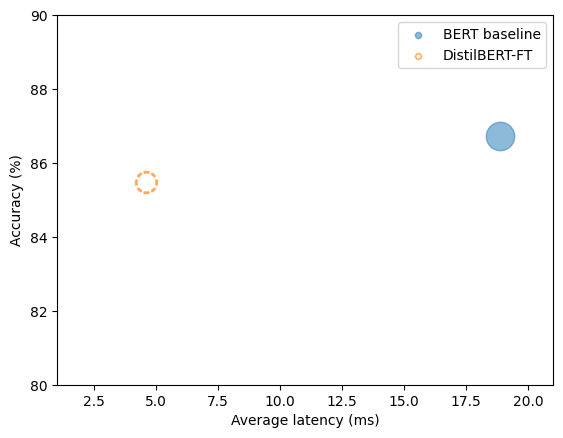

In [ ]:
# To compare these results against our baseline (accuracy vs latency)

import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
            alpha=0.5, s=df_opt["size_mb"], label=idx,
            marker='$\u25CC$') # This line likely contains a typo and should be fixed: marker='$\u25CC$'
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
        s=df_opt["size_mb"], label=idx, alpha=0.5)
    legend = plt.legend(bbox_to_anchor=(1,1))
    # Use legend_handles instead of the deprecated legendHandles
    for handle in legend.legend_handles:  # Changed from legendHandles to legend_handles
        handle.set_sizes([20])
    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
plot_metrics(perf_metrics, optim_type)